<a href="https://colab.research.google.com/github/owl-d/Basic_DeepLearning/blob/main/Doit_Ch08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***08-1 합성곱***

In [1]:
import numpy as np

In [2]:
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [3]:
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [4]:
w[0:4:2]

array([2, 5])

In [5]:
for i in range(6):
    print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [6]:
from scipy.signal import convolve

In [7]:
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [8]:
from scipy.signal import correlate

In [9]:
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [10]:
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [11]:
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [12]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])

In [13]:
from scipy.signal import correlate2d

correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [14]:
np.flip(w)

array([[0, 0],
       [0, 2]])

In [15]:
from scipy.signal import convolve2d

convolve2d(x, w, mode='valid')

array([[10, 12],
       [16, 18]])

In [16]:
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [17]:
import tensorflow as tf

In [18]:
x_4d = x.astype(np.float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

In [19]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

***08-2 풀링***

In [20]:
x = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

In [21]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

***08-3 합성곱 신경망의 구조***

In [22]:
def relu(x):
    return np.maximum(x, 0)

In [23]:
x = np.array([-1, 2, -3, 4, -5])

relu(x)

array([0, 2, 0, 4, 0])

In [24]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

***08-4 합성곱 신경망 만들고 훈련***

In [25]:
import tensorflow as tf

class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링을 적용합니다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss) #배치의 각 샘플에 대한 손실의 평균 계산

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [26]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = x ** 3 + 2 * x + 5

# 그래디언트 계산
print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


In [27]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = tf.nn.softmax(x)

# 그래디언트를 계산합니다.
print(tape.gradient(y, x))

tf.Tensor([1.99908031e-17 5.43406367e-17 1.47713165e-16], shape=(3,), dtype=float64)


In [28]:
#1. 패션 MNIST 데이터 세트 불러오기
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [29]:
#2. 사이킷런으로 훈련 데이터 세트를 훈련 세트와 검증 세트로 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [30]:
#3. 타깃을 원-핫 인코딩으로 변환하기
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [31]:
#4. 입력 데이터 준비하기
x_train = x_train.reshape(-1, 28, 28, 1) #(샘플 수, 높이, 너비, 컬러채널) 컬러채널 : 흑백이므로 1
x_val = x_val.reshape(-1, 28, 28, 1)

In [32]:
x_train.shape

(48000, 28, 28, 1)

In [33]:
#5. 입력 데이터 표준화 전처리
x_train = x_train / 255
x_val = x_val / 255

In [34]:
#6. 모델 훈련
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

In [35]:
import matplotlib.pyplot as plt

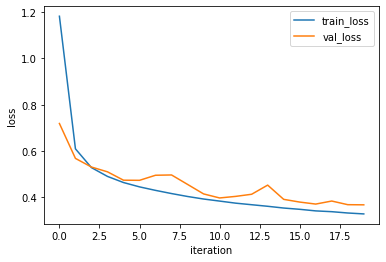

In [36]:
#7. 훈련, 검증 손실 그래프와 검증 세트의 정확도 확인
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [37]:
cn.score(x_val, y_val_encoded)

0.87225

***08-5 케라스로 합성곱 신경망 만들기***

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [39]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1))) #합성곱층
conv1.add(MaxPooling2D((2, 2))) #풀링층
conv1.add(Flatten()) #완전연결층에 주입할 수 있도록 특성 맵 펼치기
conv1.add(Dense(100, activation='relu')) #첫 번째 완전 연결층
conv1.add(Dense(10, activation='softmax')) #두 번째 완전 연결층

In [40]:
#conv1의 구조 자세히 조사
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [41]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', #아담 옵티마이저 사용
              metrics=['accuracy'])

In [42]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.4422 - accuracy: 0.8435 - val_loss: 0.3311 - val_accuracy: 0.8808
Epoch 2/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3064 - accuracy: 0.8894 - val_loss: 0.2981 - val_accuracy: 0.8935
Epoch 3/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2618 - accuracy: 0.9032 - val_loss: 0.2641 - val_accuracy: 0.9049
Epoch 4/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2292 - accuracy: 0.9157 - val_loss: 0.2540 - val_accuracy: 0.9111
Epoch 5/20
1500/1500 [==============================] - 29s 20ms/step - loss: 0.2048 - accuracy: 0.9245 - val_loss: 0.2474 - val_accuracy: 0.9107
Epoch 6/20
1500/1500 [==============================] - 29s 20ms/step - loss: 0.1841 - accuracy: 0.9324 - val_loss: 0.2465 - val_accuracy: 0.9154
Epoch 7/20
1500/1500 [==============================] - 29s 20ms/step - loss: 0.1647 - accuracy: 0.9386 - val_loss: 0.2435 -

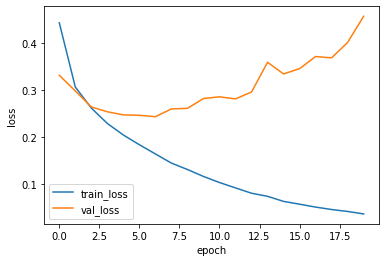

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

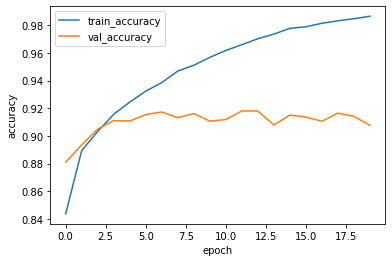

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [45]:
loss, accuracy = conv1.evaluate(x_val, y_val_encoded, verbose=0)

In [46]:
print(accuracy)

0.9075833559036255


**드롭 아웃** : 무작위로 일부 뉴런을 비활성화 시켜, 특정 뉴런에 과도하게 의존하여 훈련하는 것을 예방해 과대 적합 발생 감소

In [47]:
from tensorflow.keras.layers import Dropout

In [48]:
conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5)) #드롭아웃층 추가
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [49]:
#드롭아웃층 확인하기 : 훈련되는 가중치가 없고, 텐서의 차원을 바꾸지 않는다.
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [50]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
history = conv2.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.5067 - accuracy: 0.8171 - val_loss: 0.3524 - val_accuracy: 0.8749
Epoch 2/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.3614 - accuracy: 0.8673 - val_loss: 0.3096 - val_accuracy: 0.8878
Epoch 3/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.3257 - accuracy: 0.8804 - val_loss: 0.2842 - val_accuracy: 0.8957
Epoch 4/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.3045 - accuracy: 0.8885 - val_loss: 0.2622 - val_accuracy: 0.9050
Epoch 5/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2861 - accuracy: 0.8924 - val_loss: 0.2635 - val_accuracy: 0.9016
Epoch 6/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2704 - accuracy: 0.8982 - val_loss: 0.2484 - val_accuracy: 0.9089
Epoch 7/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2557 - accuracy: 0.9035 - val_loss: 0.2478 -

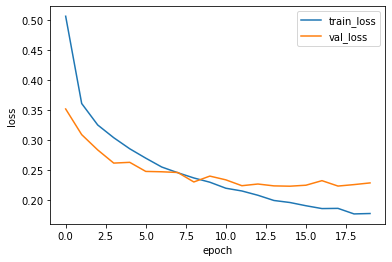

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

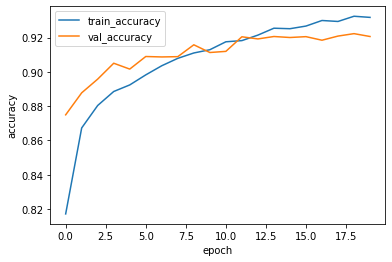

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [54]:
loss, accuracy = conv2.evaluate(x_val, y_val_encoded, verbose=0)

In [55]:
print(accuracy)

0.9205833077430725
